In [1]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu
!pip install --upgrade albumentations

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 MB 19.0 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.4/120.4 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.1
    Uninstalling google-api-core-2.11.1:
      Successfully uninstalled google-api-core-2.11.1
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.141.0
    Uninstalling google-api-python-client-2.141.0:
      Successfully uninstalled google-api-python-client-2.141.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

In [2]:
# import torch_xla
# import torch_xla.core.xla_model as xm
import tensorflow as tf
import torch
from tensorflow.data import TFRecordDataset


# print("PyTorch version:", torch.__version__)
# print("PyTorch/XLA version:", torch_xla.__version__)

In [3]:
import os


print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"))

['val', 'test', 'train']


In [4]:
import numpy as np
from albumentations import (
    CLAHE,
    Blur,
    CenterCrop,
    CoarseDropout,
    ColorJitter,
    Compose,
    GaussNoise,
    HorizontalFlip,
    Normalize,
    RandomCrop,
    RandomResizedCrop,
    RandomRotate90,
    Resize,
    RGBShift,
    ShiftScaleRotate,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2


def transform_image(image, is_train=True):
    image = image.numpy().astype(np.uint8)

    mean = [0.44094554, 0.40869614, 0.30333737]
    std = [0.28143466, 0.2477796, 0.27135006]

    if is_train:
        transforms = Compose(
            [
                Resize(height=256, width=256),
                RandomCrop(height=224, width=224),
                RandomRotate90(p=0.5),
                HorizontalFlip(p=0.5),
                ShiftScaleRotate(p=0.5, scale_limit=0.1, rotate_limit=15),
                ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
                CoarseDropout(max_holes=3, max_height=16, max_width=16, p=0.3),
                Blur(blur_limit=3, p=0.1),
                GaussNoise(var_limit=(10.0, 50.0), p=0.1),
                CLAHE(p=0.1),
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )
    else:
        transforms = Compose(
            [
                Resize(height=256, width=256),
                CenterCrop(height=224, width=224),
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )

    transformed = transforms(image=image)
    return transformed["image"]


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = example["class"]
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    id_ = example["id"]
    return image, id_


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath

In [5]:
from torch.utils.data import DataLoader, Dataset


class CustomDataset(Dataset):
    def __init__(self, file_paths, mode="train", ordered=False):
        self.file_paths = file_paths
        self.mode = mode
        self.labeled = self.mode in [
            "train",
            "val",
        ]
        self.is_train = self.mode in [
            "train",
        ]
        self.tfr_dataset = tf.data.TFRecordDataset(self.file_paths)

        ignore_order = tf.data.Options()
        if not ordered:
            ignore_order.experimental_deterministic = False

        self.tfr_dataset = list(self.tfr_dataset.with_options(ignore_order))

    def __len__(self):
        return len(self.tfr_dataset)

    def __getitem__(self, idx):
        example = self.tfr_dataset[idx]
        image, label = (
            read_labeled_tfrecord(example) if self.labeled else read_unlabeled_tfrecord(example)
        )

        transformed_image = transform_image(image, is_train=self.is_train)

        if self.labeled:
            return transformed_image, torch.tensor(label.numpy(), dtype=torch.int64)
        else:
            return transformed_image, label.numpy().decode("utf-8")

# **SOME STATISTICS AND EXAMPLES**

In [6]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
mode = "train"
batch_size = 4096

custom_dataset = CustomDataset(file_paths=get_recursive_paths(path, mode), mode=mode)
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

=== Custom Dataset Check ===
Total images in the dataset: 12753
Image tensor shape: torch.Size([3, 224, 224])
Image label: 87


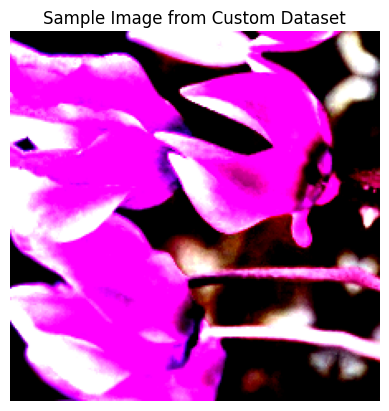

=== DataLoader Check ===


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total batches in the DataLoader: 4 (* 4096)
Images tensor batch: torch.Size([4096, 3, 224, 224])
Labels tensor batch: torch.Size([4096])
Image label: 7


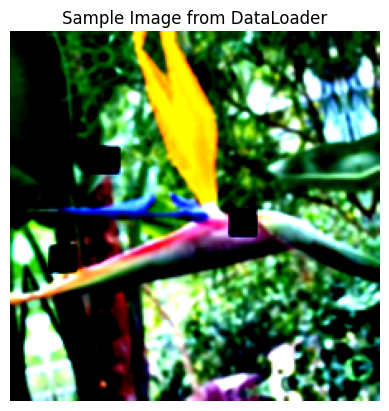

In [7]:
import random

import matplotlib.pyplot as plt


print("=== Custom Dataset Check ===")
img_tensor, lbl = custom_dataset[random.randint(0, len(custom_dataset) - 1)]
print(f"Total images in the dataset: {len(custom_dataset)}")
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Image label: {lbl}")
plt.imshow(img_tensor.permute(1, 2, 0).detach().cpu().numpy())
plt.title("Sample Image from Custom Dataset")
plt.axis("off")
plt.show()

print("=== DataLoader Check ===")
imgs_tensor, lbls_tensor = next(iter(dataloader))
print(f"Total batches in the DataLoader: {len(dataloader)} (* {batch_size})")
print(f"Images tensor batch: {imgs_tensor.shape}")
print(f"Labels tensor batch: {lbls_tensor.shape}")

index = random.randint(0, batch_size - 1)
img = imgs_tensor[index].permute(1, 2, 0).detach().cpu().numpy()
lbl = lbls_tensor[index]
print(f"Image label: {lbl}")
plt.imshow(img)
plt.title("Sample Image from DataLoader")
plt.axis("off")
plt.show()

In [8]:
from collections import Counter

import numpy as np


class_counts = dict(Counter(lbls_tensor.numpy().astype(int)))
total_samples = sum(class_counts.values())

class_frequencies = {cls: count / total_samples for cls, count in class_counts.items()}
smoothed_weights = {cls: np.log(1 / freq) for cls, freq in class_frequencies.items()}

sum_smoothed = sum(smoothed_weights.values())
normalized_weights = {cls: weight / sum_smoothed for cls, weight in smoothed_weights.items()}

CE_weights = np.array([normalized_weights[i] for i in range(max(class_counts.keys()) + 1)])

print("Нормализованные веса для weighted cross entropy:")
print(CE_weights)
print(sum(CE_weights))

Нормализованные веса для weighted cross entropy:
[0.00726142 0.01074714 0.01219158 0.01219158 0.0053797  0.00931379
 0.01348648 0.00945224 0.00895108 0.0091849  0.00879311 0.01047981
 0.00952551 0.00711188 0.00768385 0.01143411 0.00985123 0.01123728
 0.0091849  0.01123728 0.0119036  0.00912365 0.01047981 0.01165414
 0.00985123 0.00912365 0.01253218 0.01024598 0.00855632 0.00879311
 0.0088443  0.0119036  0.01294905 0.01294905 0.01143411 0.01123728
 0.0100382  0.01294905 0.01253218 0.0101392  0.00968128 0.00938173
 0.00952551 0.0088443  0.0119036  0.00795333 0.00895108 0.00703152
 0.00622872 0.0056222  0.00754939 0.00846941 0.00855632 0.00634758
 0.01143411 0.0101392  0.00874329 0.0100382  0.01123728 0.00968128
 0.01219158 0.01143411 0.00879311 0.01165414 0.0101392  0.01105922
 0.01143411 0.00535549 0.00711188 0.00900685 0.00912365 0.0088443
 0.00846941 0.00605766 0.00855632 0.00686243 0.00900685 0.00846941
 0.00968128 0.00834619 0.00826834 0.00851236 0.0091849  0.0091849
 0.01047981 0.0

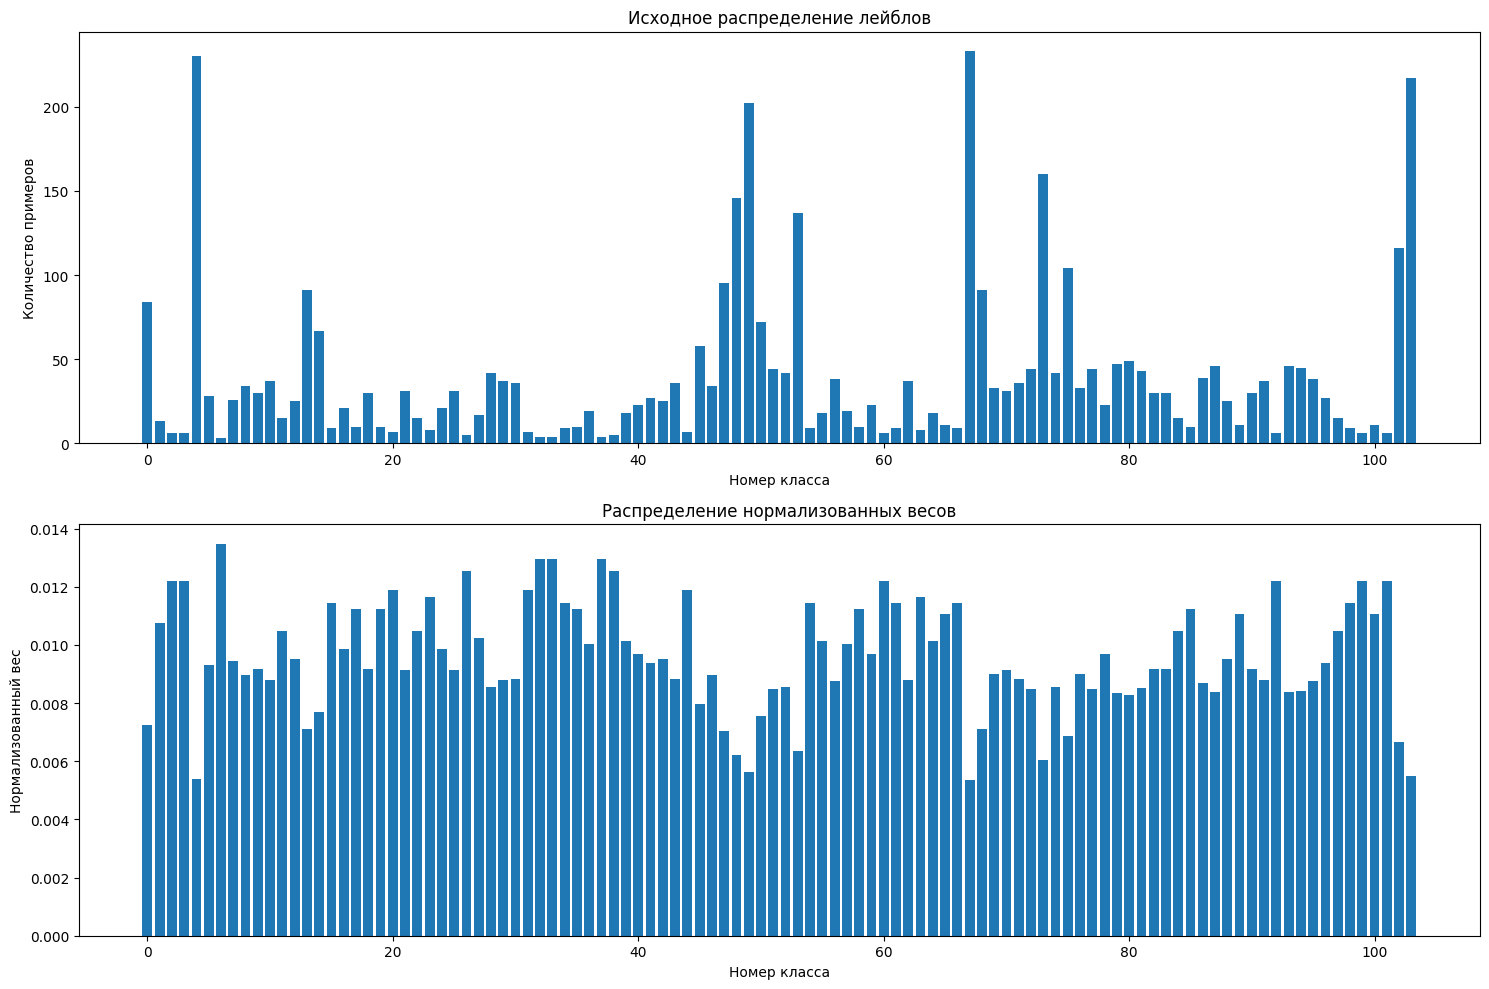

In [9]:
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]
sorted_weights = [normalized_weights[cls] for cls in sorted_classes]

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.bar(sorted_classes, sorted_counts)
plt.title("Исходное распределение лейблов")
plt.xlabel("Номер класса")
plt.ylabel("Количество примеров")

plt.subplot(2, 1, 2)
plt.bar(sorted_classes, sorted_weights)
plt.title("Распределение нормализованных весов")
plt.xlabel("Номер класса")
plt.ylabel("Нормализованный вес")

plt.tight_layout()
plt.show()

In [10]:
!pip install wandb
!pip install lightning
!pip install timm

import os

import wandb


os.environ["WANDB_API_KEY"] = "3f27a3afb5700e7542c1fa3e3f210399ca7a9fb0"

wandb.login()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 5.3 MB/s eta 0:00:0000:0100:01


wandb: Currently logged in as: alex-m-1 (projects_alexmak123). Use `wandb login --relogin` to force relogin


True

In [11]:
import pytorch_lightning
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torchmetrics.classification import MulticlassAUROC
from tqdm import tqdm


class Encoder(nn.Module):
    def __init__(self, model_name, num_classes, pretrained):
        super().__init__()
        self.model = timm.create_model(model_name, num_classes=num_classes, pretrained=pretrained)

    def forward(self, x):
        return self.model(x)


class LitModel(pytorch_lightning.LightningModule):
    def __init__(self, model_name, num_classes, pretrained, lr, CE_weights):
        super().__init__()
        self.encoder = Encoder(model_name, num_classes, pretrained)
        self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(CE_weights, dtype=torch.float32))
        self.lr = lr
        self.num_classes = num_classes
        self.activation = nn.Softmax(dim=1)

        self.val_auroc = MulticlassAUROC(num_classes=self.num_classes)

        self.save_hyperparameters()

    def forward(self, x):
        return self.encoder(x)

    def training_step(self, train_batch, batch_idx):
        train_imgs, train_lbls = train_batch
        predict_logits = self(train_imgs)
        loss = self.loss_fn(predict_logits, train_lbls)

        predict_probs = self.activation(predict_logits)
        train_f1_score = f1_score(
            train_lbls.detach().cpu().numpy(),
            torch.argmax(predict_probs, dim=1).detach().cpu().numpy(),
            average="macro",
        )

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_f1_score", train_f1_score, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("learning_rate", current_lr, on_epoch=True, prog_bar=True, sync_dist=True)

        return loss

    def validation_step(self, val_batch, batch_idx):
        val_imgs, val_lbls = val_batch
        predict_logits = self(val_imgs)
        loss = self.loss_fn(predict_logits, val_lbls)

        predict_probs = self.activation(predict_logits)
        val_f1_score = f1_score(
            val_lbls.detach().cpu().numpy(),
            torch.argmax(predict_probs, dim=1).detach().cpu().numpy(),
            average="macro",
        )

        self.val_auroc.update(predict_probs, val_lbls)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_f1_score", val_f1_score, on_epoch=True, prog_bar=True, sync_dist=True)

        return loss

    def on_validation_epoch_end(self):
        val_roc_auc = self.val_auroc.compute()
        self.log("val_roc_auc", val_roc_auc, on_epoch=True, prog_bar=True, sync_dist=True)
        self.val_auroc.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=5,
            threshold=1e-1,
            cooldown=7,
            min_lr=1e-4,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"},
        }

In [12]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)


set_seed(42)

In [14]:
torch.cuda.empty_cache()

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import RandomSampler


try:
    os.environ.pop("TPU_PROCESS_ADDRESSES")
except KeyError:
    print("already done")
try:
    os.environ.pop("CLOUD_TPU_TASK_ID")
except KeyError:
    print("already done")

num_epochs = 300
batch_size = 128
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

custom_dataset_train = CustomDataset(file_paths=get_recursive_paths(path, "train"), mode="train")
custom_dataset_val = CustomDataset(file_paths=get_recursive_paths(path, "val"), mode="val")

# train_sampler = RandomSampler(custom_dataset_train, num_samples=len(custom_dataset_train), replacement=True)

train_dataloader = DataLoader(
    custom_dataset_train, batch_size=batch_size, shuffle=True, num_workers=4
)
val_dataloader = DataLoader(custom_dataset_val, batch_size=batch_size, num_workers=4)

xlm_model = LitModel(
    model_name="resnet50", num_classes=104, pretrained=True, lr=1e-2, CE_weights=CE_weights
)

logger = WandbLogger(
    project="kaggle_top11", name="res50_128_224_augs_CELw_shcuffle_tune", log_model=20
)
# logger.watch(xlm_model, log="all", log_freq=25) # log gradients
checkpoint_callback = ModelCheckpoint(
    monitor="val_f1_score",
    mode="max",
    save_top_k=3,
    filename="{epoch}-{val_f1_score:.4f}",
)

trainer = pytorch_lightning.Trainer(
    logger=logger,
    max_epochs=num_epochs,
    accelerator="cuda",
    callbacks=[checkpoint_callback],
    strategy="ddp_notebook",
    devices=-1,
    log_every_n_steps=10,
)

trainer.fit(xlm_model, train_dataloader, val_dataloader)

# logger.experiment.unwatch(xlm_model)

already done
already done


NameError: name 'exit' is not defined

In [69]:
best_model_path = "./kaggle_top11/yrmp2h2u/checkpoints/epoch=95-val_f1_score=0.7565.ckpt"

model = LitModel.load_from_checkpoint(best_model_path)
model.eval()
model = model.cpu()

In [33]:
!tar -czvf checkpoints.tar.gz ./kaggle_top11/yrmp2h2u/checkpoints/*.ckpt

./kaggle_top11/yrmp2h2u/checkpoints/epoch=92-val_f1_score=0.7530.ckpt
./kaggle_top11/yrmp2h2u/checkpoints/epoch=94-val_f1_score=0.7519.ckpt
./kaggle_top11/yrmp2h2u/checkpoints/epoch=95-val_f1_score=0.7565.ckpt


In [34]:
from IPython.display import FileLink, display


display(FileLink("checkpoints.tar.gz", result_html_prefix="Нажмите здесь, чтобы скачать: "))

/kaggle/working/checkpoints.tar.gz

In [53]:
!pip install onnxruntime

In [ ]:
import numpy as np
import onnxruntime
import torch.onnx
from torch.utils.data import DataLoader


dummy_input = torch.randn(1, 3, 224, 224)

output_filename = f"{'.'.join(best_model_path.split('/')[-1].split('.')[:2])}.onnx"

torch.onnx.export(model, dummy_input, output_filename, opset_version=11)

test_dataset = CustomDataset(file_paths=get_recursive_paths(path, "test"), mode="test")

ort_session = onnxruntime.InferenceSession(output_filename)

test_preds_dict = dict()

for batch in tqdm(test_dataset):
    img, lbl = batch
    img = img.unsqueeze(0)

    input_name = ort_session.get_inputs()[0].name
    input_data = img.numpy()

    pred = ort_session.run(None, {input_name: input_data})[0]

    test_preds_dict[lbl] = np.argmax(pred, axis=1)[0]

print(test_preds_dict)
print("Предсказания выполнены.")

 62%|██████▏   | 4560/7382 [1:02:30<36:55,  1.27it/s]

In [ ]:
test_preds_df = pd.DataFrame(
    {
        "id": test_preds_dict.keys(),
        "label": test_preds_dict.values(),
    }
)

test_preds_df = test_preds_df.reset_index(drop=True)
test_preds_df.to_csv(f"{output_filename}advanced_solution.csv", index=False)